#Text-To-Sql using LangGraph

Creating Database

In [ ]:
#importing to create and interact with database and tables
import sqlite3

In [ ]:
connection = sqlite3.connect("employee.db")

In [ ]:
cursor = connection.cursor()

In [ ]:
#query to create a table
table_creation_query="""
CREATE TABLE IF NOT EXISTS employees (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [ ]:
cursor.execute(table_creation_query)

In [ ]:
#format of query for the insertion of data
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

In [ ]:
employee_data = [
    (1, "Sunny", "Savita", "sunny.sv@abc.com", "2023-06-01", 50000.00),
    (2, "Arhun", "Meheta", "arhun.m@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00),
    ]

In [ ]:
#inserting data into the table
cursor.executemany(insert_query,employee_data)

In [ ]:
connection.commit()

In [ ]:
cursor.execute("select * from employees;")

In [ ]:
#displaying the data of the table
for row in cursor.fetchall():
    print(row)

Initializing the llm model for the query generation

In [1]:
#using langchain api and huggingface api for llms
import os
os.environ["LANGCHAIN_API_KEY"] = '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'
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="CourseLanggraph"

In [2]:
from huggingface_hub import login
login()

In [3]:
#using hugging face llm model for the query generation
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace

llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

chat = ChatHuggingFace(llm=llm, verbose=True)

Creating Multi-Agent Application using LangGraph

In [272]:
from typing import Annotated

from typing_extensions import TypedDict
from operator import add

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [340]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    prompt: list[str]
    schema : list[str]
    query : list[str]
    results: Annotated[list[str], add]

graph_builder = StateGraph(State)

In [341]:
#agent to get the table schema
def get_table_schema(state, table_name="employees"):
    schema_response = ""
    try:
        cursor = connection.cursor()
        query = f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';"
        cursor.execute(query)
        result = cursor.fetchone()

        if result:
            schema_response = f"Schema for table '{table_name}':\n{result[0]}"
        else:
            schema_response = f"Table '{table_name}' does not exist."
    except sqlite3.Error as e:
        schema_response = f"An error occurred: {e}"
    finally:
        cursor.close()
    state['schema'] = [schema_response]

    return state
    # return state


In [342]:
# Add nodes (functions)
graph_builder.add_node("get_table_schema", get_table_schema)

In [343]:
# Define the edges between nodes
graph_builder.add_edge(START, "get_table_schema")

In [344]:
#agent to generate the query using llm
def query_gen(state: State):
    messages = [
    ("system", "Act as an MYSQL expert. And answer the prompt . Don't explain the answer, Just return the MYSQL query and nothing else."),
    ("human", state['prompt'][0]+state['schema'][0]),]
    h = chat.invoke(messages)
    state['query'] = [h.content]
    return state
# Add nodes (functions)
graph_builder.add_node("query_gen", query_gen)

In [345]:
# Define the edges between nodes
graph_builder.add_edge("get_table_schema","query_gen")

In [346]:
#agent to execute the query generated by llm
def results_gen(state: State):
    # print(state)
    cursor.execute(state['query'][0])
    result = []

    for row in cursor.fetchall():
        result.append(row)
    return {"results": [result]}
    return state
# Add nodes (functions)
graph_builder.add_node("results_gen", results_gen)

In [347]:
# Define the edges between nodes
graph_builder.add_edge("query_gen","results_gen")

In [348]:
# Define the edges between nodes
graph_builder.add_edge("results_gen",END)

In [349]:
# Compile the graph
graph = graph_builder.compile()

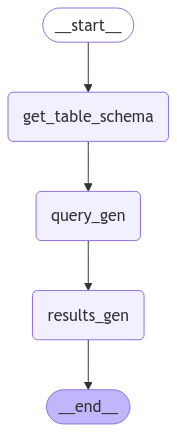

In [350]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
#prompt input
def stream_graph_updates(user_input: str,results):
    for event in graph.stream({"prompt": [user_input]}):
        for value in event.values():
            results = value["results"]
    return results



user_input = input("User: ")
if user_input.lower() in ["quit", "exit", "q"]:
    print("Goodbye!")

print(stream_graph_updates(user_input,[]))


[[('Arhun', 'Meheta', 'arhun.m@gmail.com', 60000.0)]]
